## 1. Импорт библиотек и настройка параметров

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

import os

import pandas_profiling

In [2]:
# Фиксируем параметры для воспроизводимости экспериментов:

RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('17/07/2021')

In [3]:
# Увеличиваем число отображаемых строк и столбцов в pandas:

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [4]:
# Задаем размер графиков по умоланию:

matplotlib.rcParams['figure.figsize'] = (12, 8)

In [5]:
# При выполнении на kaggle раскомментировать этот блок:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
# PATH_to_file = '/kaggle/input/sf-dst-scoring/'

# При выполнении локально раскомментировать этот блок:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = './data/'

./data/test.csv
./data/train.csv
./data/sample_submission.csv


## 2. Импорт данных

In [6]:
# Загружаем данные:

df_train = pd.read_csv(PATH_to_file + 'train.csv')
df_test = pd.read_csv(PATH_to_file + 'test.csv')

print('Размер тренировочного датасета: ', df_train.shape)
display(df_train.sample(3))

print('Размер тестового датасета: ', df_test.shape)
display(df_test.sample(3))

Размер тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
18564,20481,28JAN2014,SCH,M,24,Y,Y,0,0,-2.593850,2,50,1,2,40000,4,3,N,0
27366,108610,28APR2014,SCH,F,36,N,N,1,0,-2.356283,1,70,1,3,35000,3,3,N,0
61667,67265,16MAR2014,UGR,M,39,Y,Y,0,0,-2.742806,2,80,2,3,700000,1,3,Y,0


Размер тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
32629,56646,05MAR2014,SCH,M,63,Y,Y,0,0,-1.674370,0,80,2,3,200000,1,4,Y
31459,55537,04MAR2014,GRD,F,67,N,N,0,0,-2.126323,5,50,2,3,25000,1,4,N
6834,104841,23APR2014,SCH,M,62,N,N,0,0,-0.905297,0,60,2,3,30000,1,4,N


#### Описания полей датасета:

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [7]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет:

df_train['Train'] = 1  # помечаем где у нас трейн
df_test['Train'] = 0  # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True)  # объединяем

In [8]:
# Проверяем получившийся датасет:

print('Размер суммарного датасета: ', df.shape)
display(df.sample(3))

Размер суммарного датасета:  (110148, 20)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
98380,26546,02FEB2014,ACD,M,35,Y,Y,0,0,-2.567828,6,50,2,3,200000,1,4,Y,NaN,0
49499,90002,06APR2014,SCH,M,53,N,N,0,0,-2.730769,1,80,2,3,21000,1,4,N,0.0,1
99612,65105,14MAR2014,SCH,M,35,Y,Y,0,0,-1.361446,2,50,2,3,50000,1,3,N,NaN,0


## 3. Предварительный анализ данных

In [9]:
# Предварительный анализ данных удобно производить с помощью pandas_profiling, но,
# что-бы не ждать каждый раз генерации отчета, на данный момент его вызов закомментирован.
# Интересующие нас сведения мы получим более "традиционными" средствами.

# pandas_profiling.ProfileReport(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

None

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

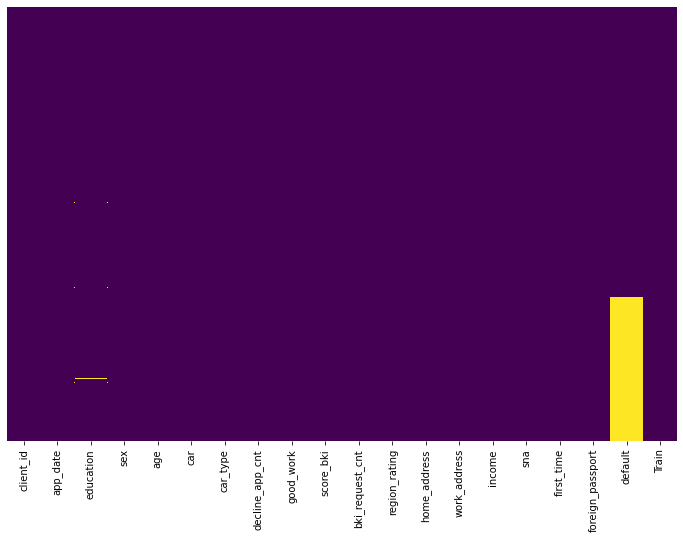

In [10]:
# Посмотрим на тип данных и наличие пропусков:

display(df.info())

display(df.isna().sum())

sns_heatmap = sns.heatmap(df.isnull(),
                          yticklabels=False,
                          cbar=False,
                          cmap='viridis')

Мы видим что пропуски у нас есть только в столбце education и их совсем мало (менее 1%). Можно сразу заняться их заполнением.

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

<AxesSubplot:xlabel='education', ylabel='count'>

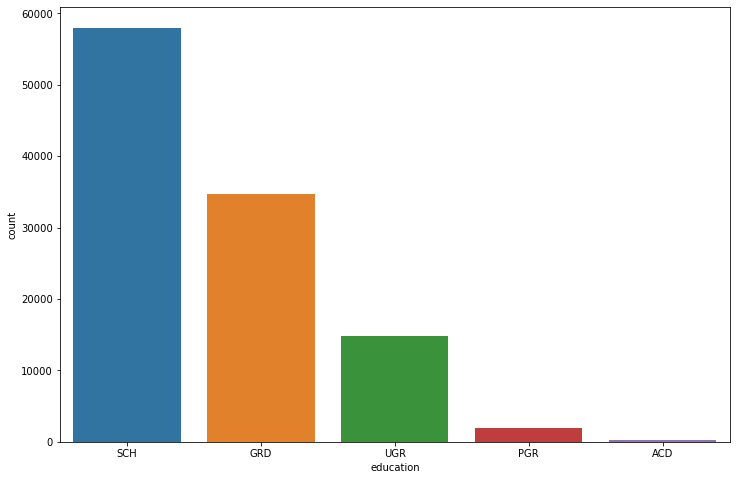

In [11]:
# Посмотрим на распределение образования:

display(df['education'].value_counts())

sns.countplot(x='education', data=df)

In [12]:
# Всего у нас в датасете 5 типов образования, вариант 'SCH' встречается в более чем 50% случаев.
# Заполним пропуски в столбце 'education' именно им:

df.education.fillna(df.education.value_counts().idxmax(), inplace=True)

In [13]:
# Сразу преобразуем данные признака education в числа:

label_encoder = LabelEncoder()

df['education'] = label_encoder.fit_transform(df['education'])

#### Итоги предварительного анализа:

1. В тренировочной выборке содержатся данные о 73799 клиентах, в тестовой о 36349. Всего 110148 клиентов.
2. Пропуски были только в переменной 'education' (478 пропусков, менее 1%), заменены наиболее частым значением.
3. Всего у нас 19 признаков, из них:
    * 'client_id' - уникальный числовой признак, не нужный при анализе
    * 'default' - целевая переменная
    * 'Train' - созданный нами признак для разделения датасета
    * временной ряд - 1 ('app_date')
    * бинарные - 5 ('sex', 'car', 'car_type', 'good_work', 'foreign_passport')
    * категориальные - 6 ('education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time')
    * числовые - 5 ('age','decline_app_cnt','score_bki','bki_request_cnt','income')


In [14]:
# Создадим списки бинарынх, категориальных и числовых переменных для удобства работы с ними:

bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

cat_cols = ['education', 'region_rating',
            'home_address', 'work_address', 'sna', 'first_time']

num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

## 4. Работа с признаками

### 4.1 app_date

In [15]:
# Взглянем поближе на признак app_date:

df.app_date.sample(5)

37287    24JAN2014
23505    26JAN2014
55708    29JAN2014
73228    17APR2014
77132    05MAR2014
Name: app_date, dtype: object

In [16]:
# Для начала приведем дату в удобный для работы формат:

df.app_date = pd.to_datetime(df.app_date)

In [17]:
# Выясняем начало и конец периода наблюдений нашего датасета:

display(df.app_date.min(), df.app_date.max())

Timestamp('2014-01-01 00:00:00')

Timestamp('2014-04-30 00:00:00')

In [18]:
# На основе даты сгенерируем новые признаки:

df['app_day'] = df.app_date.dt.day.astype('int')  # число
df['app_month'] = df.app_date.dt.month.astype('int')  # месяц
df['app_weekday'] = df.app_date.dt.weekday.astype('int')  # день недели
df['days'] = (df.app_date - df.app_date.min()
              ).dt.days.astype('int')  # число дней с начала наблюдений

<AxesSubplot:>

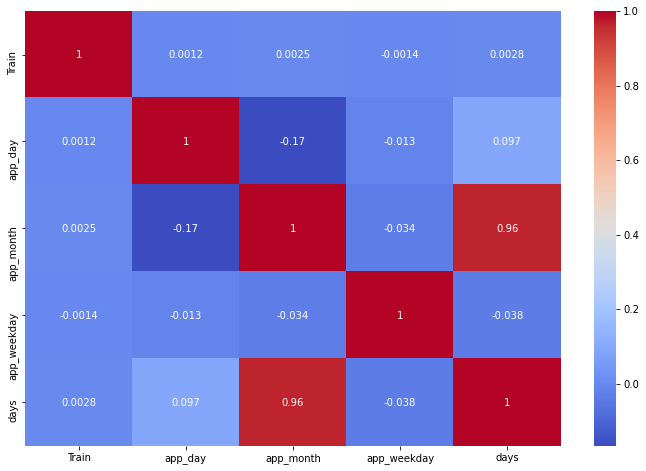

In [19]:
# Посмотрим матрицу корреляции новых признаков:

sns.heatmap(df.iloc[:, 19:].corr(), annot=True, cmap='coolwarm')

In [20]:
# Из матрицы корреляции видно что 'app_month' почти полностью скоррелирован с 'app_day'.
# Один из признаков надо удалить, пусть это будет 'app_month':

df.drop(['app_month'], axis=1, inplace=True)

In [21]:
# Так-же можно удалить ставший ненужным признак 'app_date':

df.drop(['app_date'], axis=1, inplace=True)

In [22]:
# Добавляем созданные переменные в список числовых:

num_cols.extend(['app_day', 'app_weekday', 'days'])

### 4.2 Бинарные переменные

In [23]:
# Посмотрим как закодированы наши бинарные переменные:

df[bin_cols].sample(5)

,sex,car,car_type,good_work,foreign_passport
7909,M,Y,Y,0,Y
1757,M,Y,Y,0,Y
52598,M,Y,Y,1,N
25859,M,N,N,0,N
1345,F,N,N,0,N


In [24]:
# Преобразуем бинарные переменные в 0 и 1:

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

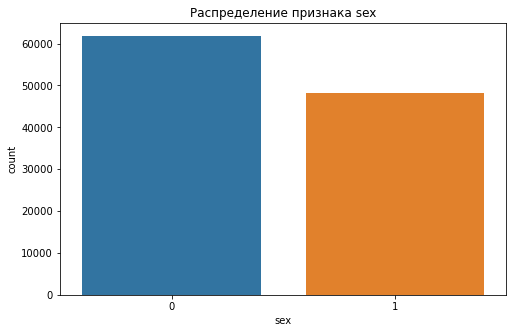

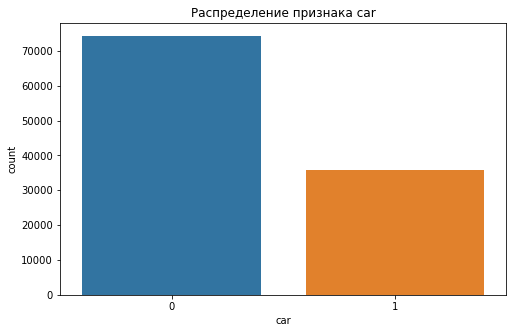

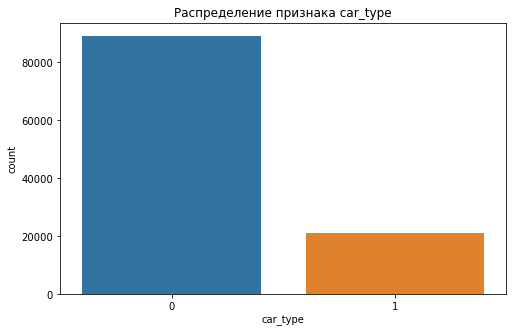

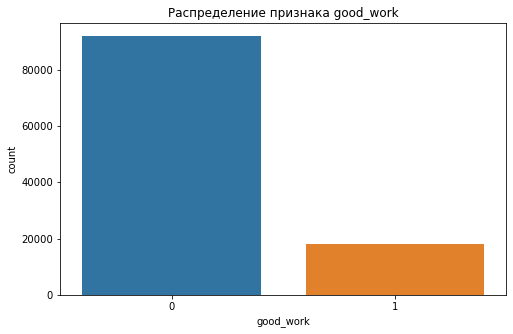

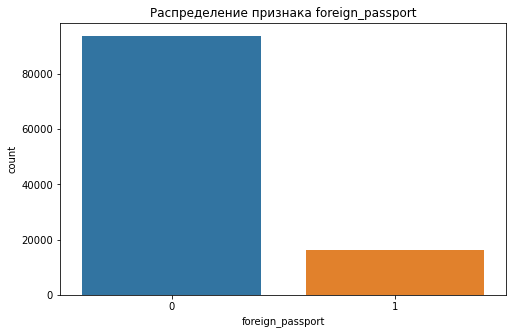

In [25]:
# Построим графики распределения бинарных переменных:

for col in bin_cols:
    plt.figure(figsize=(8, 5))
    #sns.countplot(df[col])
    sns.countplot(x=col, data=df)
    plt.title(f'Распределение признака {col}')

За кредитом чаще обращаются женщины, люди без хорошей работы, без загранпаспорта и без машины.

<AxesSubplot:>

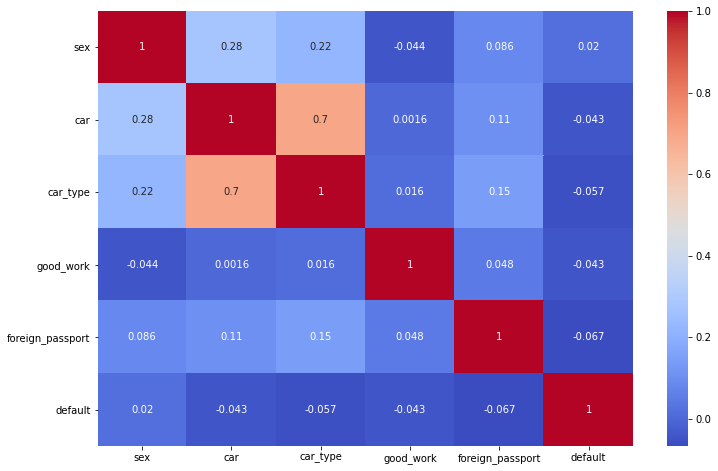

In [26]:
# Построим матрицу корреляций для бинарных признаков:

sns.heatmap(df[bin_cols+['default']].corr(), annot=True, cmap='coolwarm')

In [27]:
# Видно что признаки 'car' и 'car_type' сильно скоррелированы между собой.
# Можно было-бы удалить один из них, но лучше попробовать объединить их в единый признак.
# Если сложить их друг с другом, то получится категориальный признак, где 0 - отсутствие машины,
# 1 - отечественная машина, 2 - иномарка.

df.car = (df.car + df.car_type)

In [28]:
# Удаляем ставший ненужным признак 'car_type':

df.drop(['car_type'], axis=1, inplace=True)

In [29]:
# Переносим признак 'car' из бинарных в категориальные:

bin_cols.remove('car')
bin_cols.remove('car_type')
cat_cols.append('car')

<AxesSubplot:>

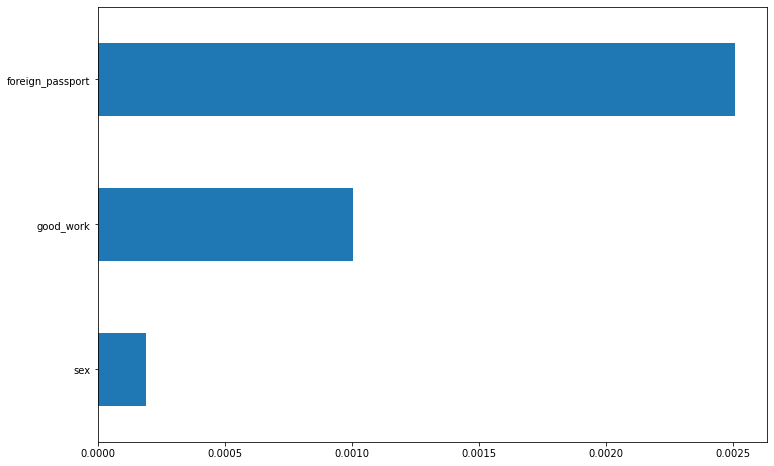

In [30]:
# Проверяем значимость бинарных переменных:

train_df = df[df['Train'] == 1]  # берем только "тренирововчные" данные

imp_cat = pd.Series(mutual_info_classif(train_df[bin_cols], train_df['default'],
                                        discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Все переменные значимые, все оставляем.

### 4.3 Числовые переменные

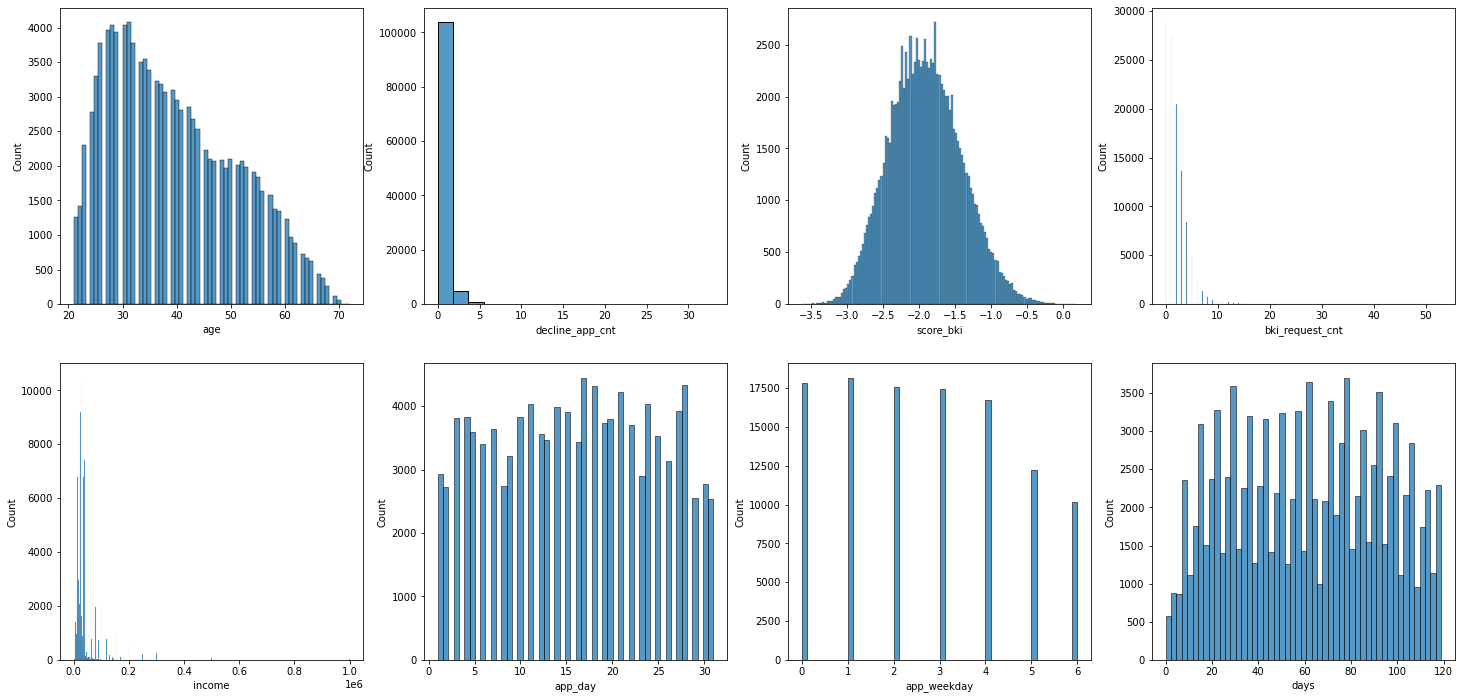

In [31]:
# Посмотрим на распределение числовых переменных:

fig, axes = plt.subplots(2, 4, figsize=(25, 12))
for col, i in zip(num_cols, range(8)):
    sns.histplot(df[col], kde=False, ax=axes.flat[i])

In [32]:
# Аномальных значений (вроде отрицательной зарплаты или возраста меньеше 18 лет) нет, значит считать
# какие-либо значения выбросами нельзя.
# Видно что график распределения переменных 'age', 'decline_app_cnt', 'bki_request_cnt'
# и 'income' смещены вправо. Чтобы сделать их распределение более нормальным прологарифмируем их:

for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    df[i] = np.log(df[i] + 1)

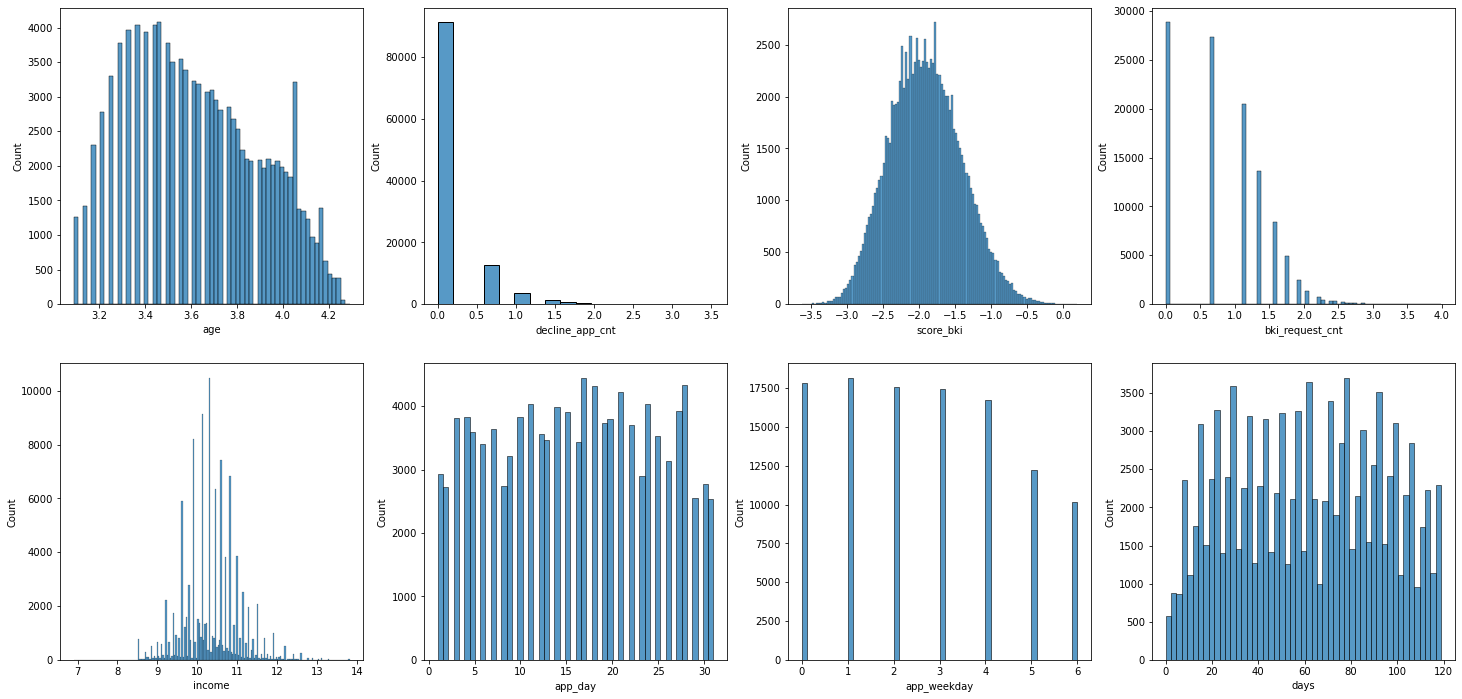

In [33]:
# Посмотрим как изменилось распределение:

fig, axes = plt.subplots(2, 4, figsize=(25, 12))
for col, i in zip(num_cols, range(8)):
    sns.histplot(df[col], kde=False, ax=axes.flat[i])

После логарифмирования распределение признаков 'age' и 'income' улучшилось, а 'decline_app_cnt', 'bki_request_cnt' все-равно сильно смещены вправо. Для исправления ситуации можно превратить их в категориальные переменные.

In [34]:
# Берем экспоненту, что-бы вернуть переменные к исходному состоянию:

for i in ['decline_app_cnt', 'bki_request_cnt']:
    df[i] = np.exp(df[i]) - 1

In [35]:
# Переводим их в категориальные признаки по принципу 1-2-3.."много". Судя по графикам, 
# для decline_app_cnt "много" это 3 и больше, а для bki_request_cnt 6 и больше.

df.decline_app_cnt = df.decline_app_cnt.apply(lambda x: x if x < 3 else 3)
df.bki_request_cnt = df.bki_request_cnt.apply(lambda x: x if x < 6 else 6)

In [36]:
# Переносим признаки из числовых в категориальные:

num_cols.remove('decline_app_cnt')
num_cols.remove('bki_request_cnt')
cat_cols.extend(['decline_app_cnt', 'bki_request_cnt'])

<AxesSubplot:>

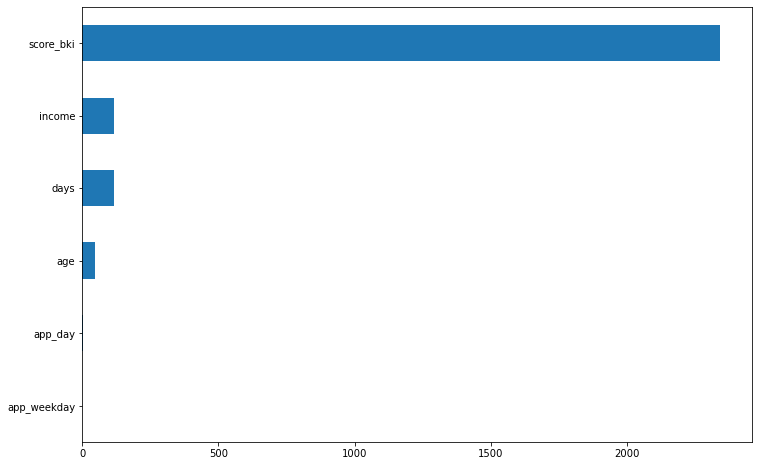

In [37]:
# Проверим значимость числовых переменных:

imp_num = pd.Series(f_classif(train_df[num_cols], train_df['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

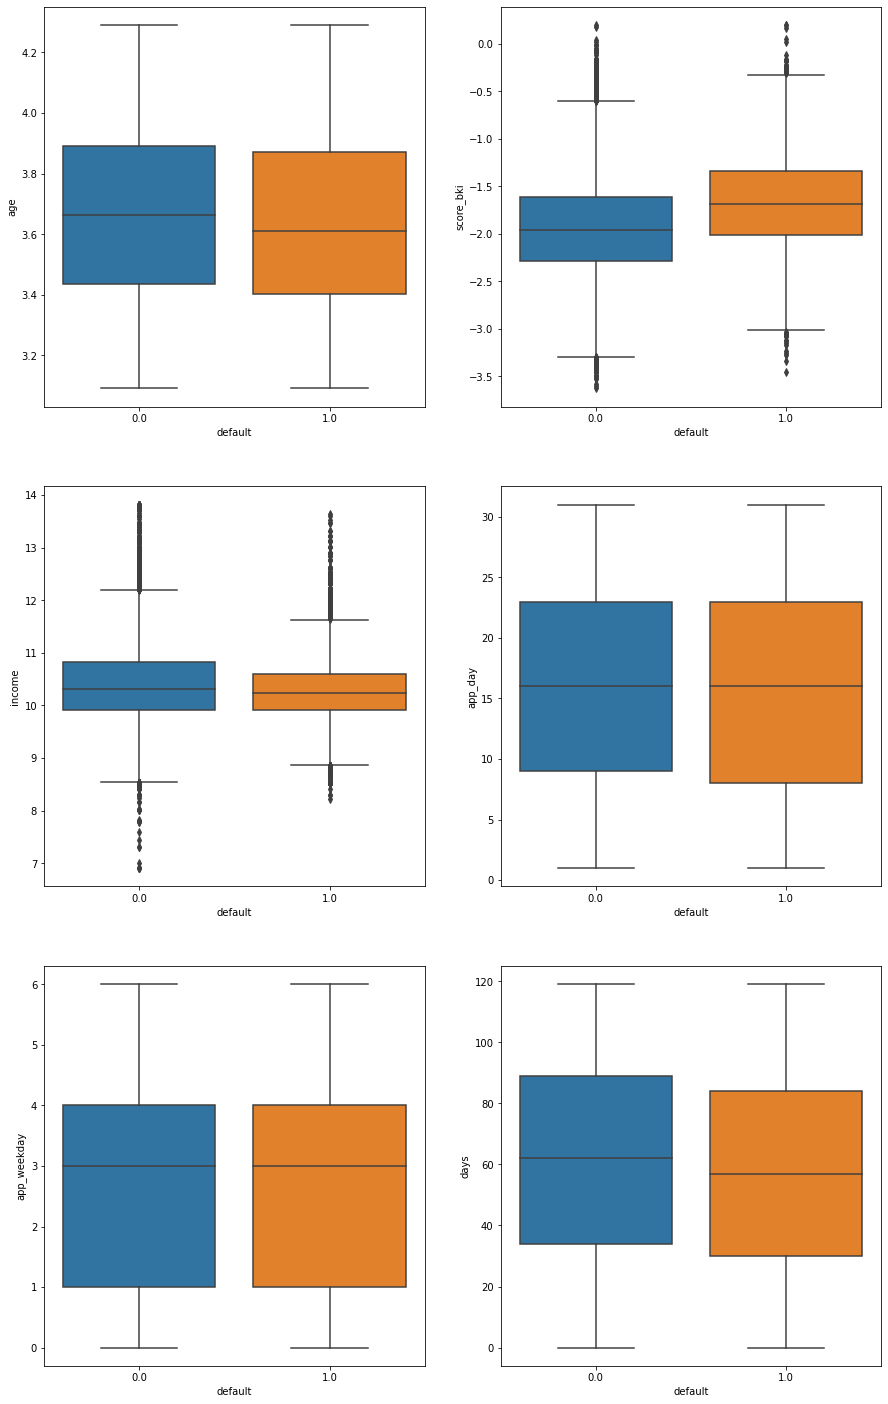

In [38]:
# Построим боксплоты, что-бы посмотреть выбросы и определеть какие признаки
# не сильно отличаются для целевой переменной:

fig, axes = plt.subplots(3, 2, figsize=(15, 25))
for col, i in zip(num_cols, range(6)):
    sns.boxplot(x=df.default, y=df[col], ax=axes.flat[i])

In [39]:
# Судя по боксплотам дефолт не зависит от дня недели. По графику значимости он тоже не важен.
# Можно этот признак удалить:

df.drop(['app_weekday'], axis=1, inplace=True)
num_cols.remove('app_weekday')

<AxesSubplot:>

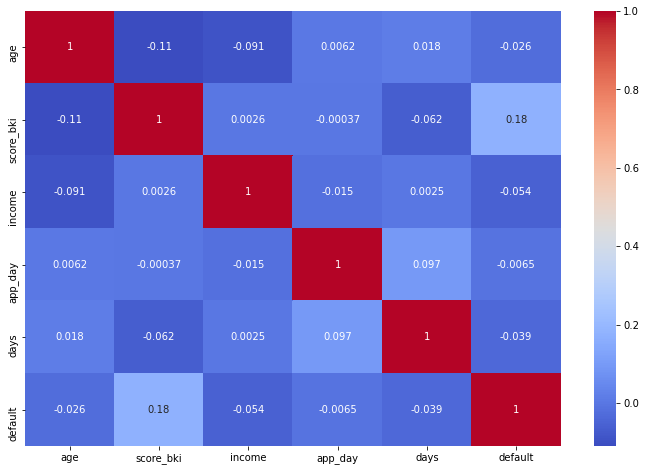

In [40]:
# Построим матрицу корреляций для числовых признаков:

sns.heatmap(df[num_cols+['default']].corr(), annot=True, cmap='coolwarm')

Сильно скоррелированных числовых признаков нет, оставляем их все.

### 4.3 Категориальные переменные

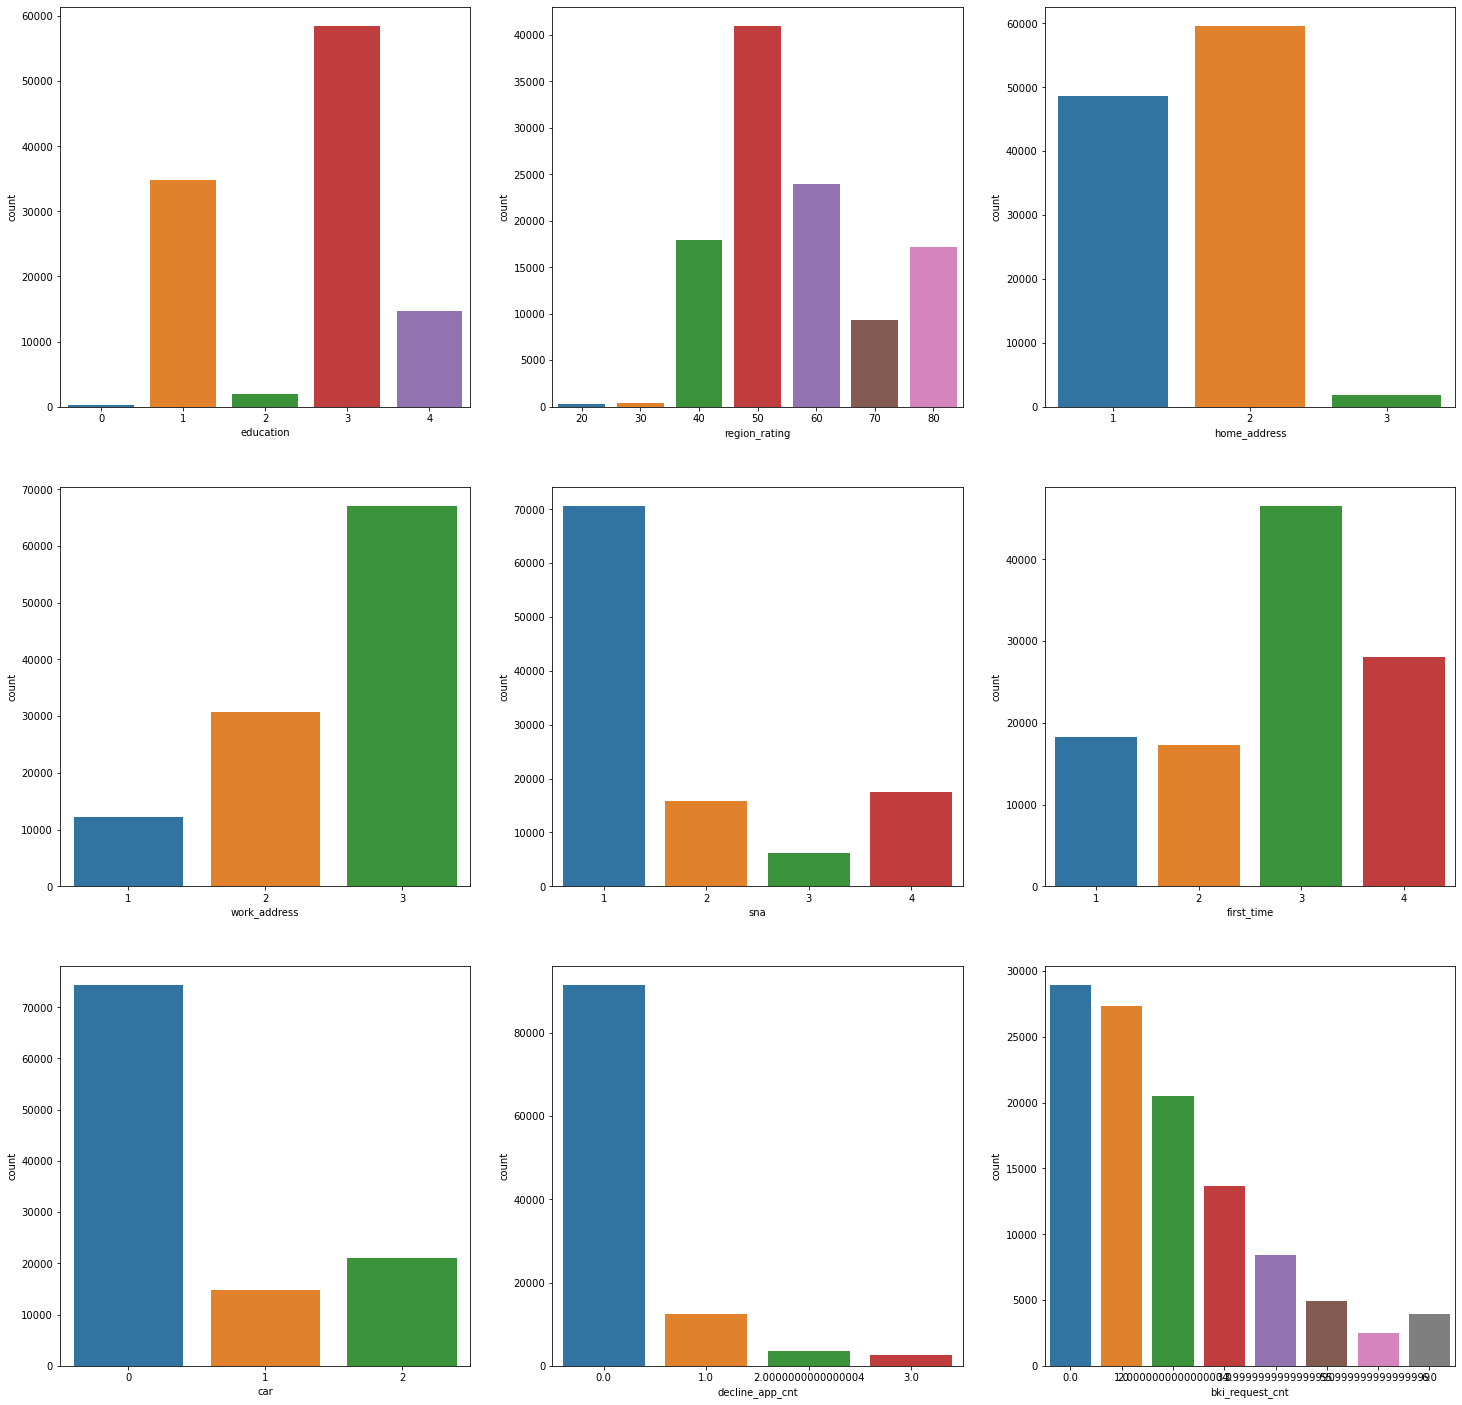

In [41]:
# Посмотрим на графики распределения категориальных переменных в зависимости от их количества:

fig, axes = plt.subplots(3, 3, figsize=(25, 25))
for col, i in zip(cat_cols, range(9)):
    sns.countplot(x=col, data=df, ax=axes.flat[i])

<AxesSubplot:>

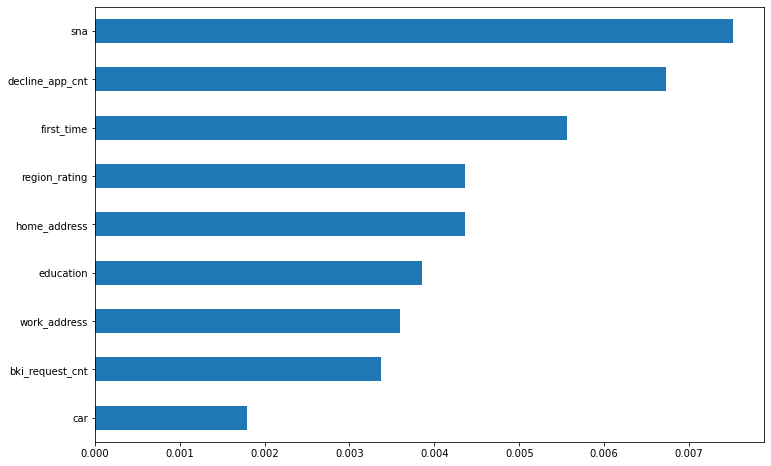

In [42]:
# Проверим значимость категориальных переменных:

imp_cat = pd.Series(mutual_info_classif(train_df[cat_cols],
                                        train_df.default, discrete_features=True),
                    index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<AxesSubplot:>

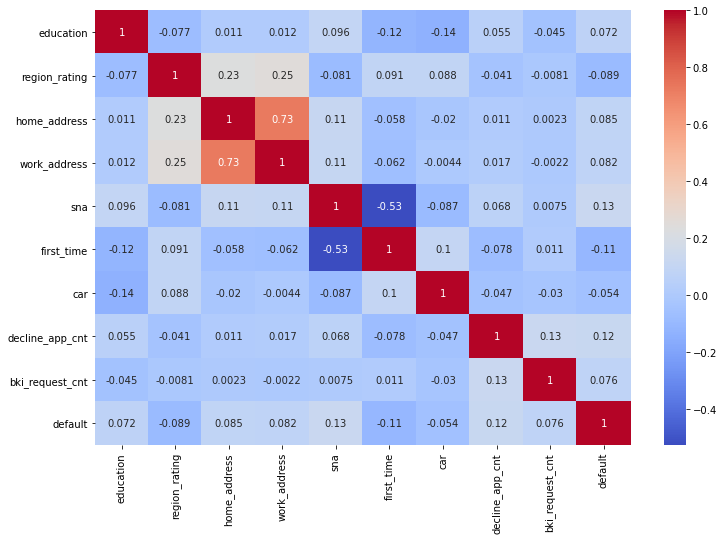

In [43]:
# Построим матрицу корреляций для категориальных признаков:

sns.heatmap(df[cat_cols+['default']].corr(), annot=True, cmap='coolwarm')

In [44]:
# Рабочий и домашний адреса сильно скоррелированы друг с другом. Можно было-бы один из признаков
# удалить, но, судя по графику, они оба значимы для модели. Попробуем объединить их методом декомпозиции:

# Выберем из датасета нужные колонки:
data = df[['work_address', 'home_address']].values

# Создадим Scaler instance:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Из двух столбцов сделаем один путем усечения ненужной информации:
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['address'] = pca_data

# Уберем ненужные колонки:
df = df.drop(['home_address', 'work_address'], axis=1)

# Приведем в порядок списки:
cat_cols.remove('home_address')
cat_cols.remove('work_address')
cat_cols.append('address')

## 5. Подготовка данных для построения модели

In [45]:
# Разделяем датасет обратно на тренировочный и тестовый:

train = df.query('Train == 1').drop(['Train'], axis=1)
test = df.query('Train == 0').drop(['Train'], axis=1)

# Выделяем целевой признак 'default' из тренировочных данных в отдельный датасет:
Y = train.default.values

In [46]:
# Проверяем что размеры датасетов совпадают с исходными:

display(f'Размер тренировочного датасета: {train.shape}',
        f'Размер тестового датасета: {test.shape}')

'Размер тренировочного датасета: (73799, 18)'

'Размер тестового датасета: (36349, 18)'

In [47]:
# Проводим стандартизацию числовых признаков:

scaler = StandardScaler()
train_num = scaler.fit_transform(train[num_cols].values)

In [48]:
# Преобразуем категориальные переменные при помощи OneHotEncoder:

encoder = OneHotEncoder(sparse=False)
train_cat = encoder.fit_transform(train[cat_cols].values)

In [49]:
# Объединяем стандартизованные числовые, бинарные и закодированные категориальные переменные:

X = np.hstack([train_num, train[bin_cols].values, train_cat])

In [50]:
# Посмотрим размер получившегося признакового пространства:

display(f'Размер тренировочных данных: {np.shape(train_df)}')

'Размер тренировочных данных: (73799, 21)'

In [51]:
# Разделим данные для обучения следующим образом:

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.20,
                                                    random_state=RANDOM_SEED)

## 6. Построение модели

### 6.1 "Наивная" модель

In [52]:
# Для начала строим модель с "дефолтными" настройками. Увеличим только число итераций,
# т.к. с базовым значением (100 итераций) алгоритм не сходится, нужно минимум 276:

model_0 = LogisticRegression(max_iter=276, random_state=RANDOM_SEED)
model_0.fit(X_train, y_train)

LogisticRegression(max_iter=276, random_state=42)

In [53]:
# Делаем предсказание:

y_pred = model_0.predict(X_test)

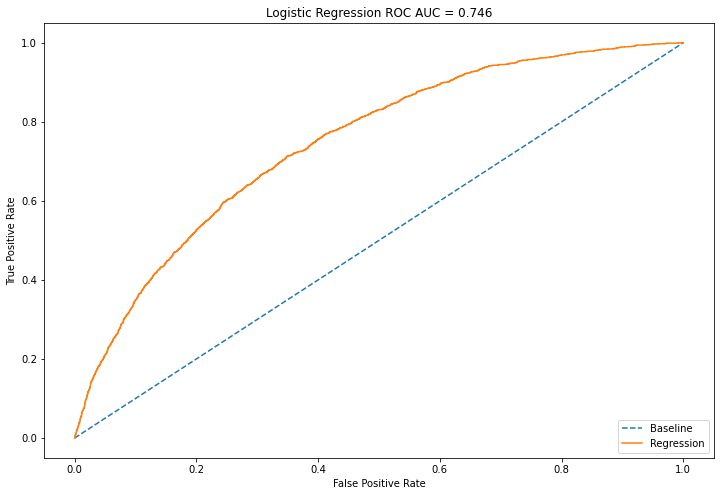

In [54]:
# В качестве метода оценки прогностической способности модели используем ROC-анализ:

probs = model_0.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [55]:
# Посмотрим на различные метрики:

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.8751
f1_score: 0.0436
recall_score: 0.023
MSE: 0.1249


<AxesSubplot:>

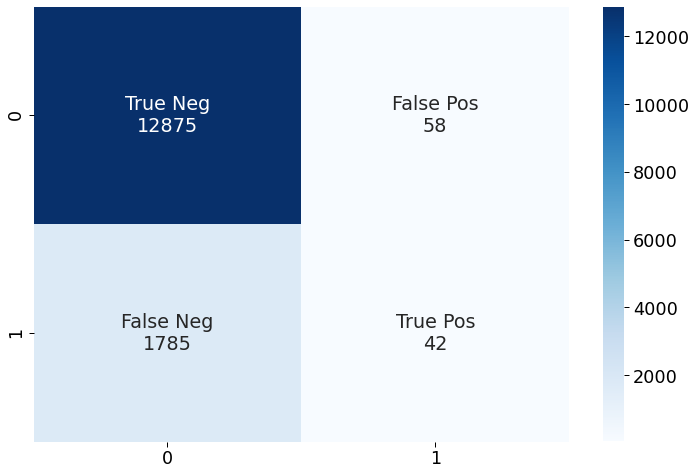

In [56]:
# Посмотрим confusion matrix:

sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=labels, fmt='', cmap='Blues')

<b>Результаты</b> "наивной модели" вышли очень плохими: мы получили очень большую ошибку второго рода. Несмотря на это площадь под ROC кривой оказалась не такой уж плохой из-за того что она плохо оценивает эффективность алгоритма на несбалансированных данных. За-то f1-score сразу "хорошо" оценил нашу модель.

### 6.2 Работа с гиперпараметрами

In [57]:
# Попробуем "покрутить" гиперпараметры, а так-же увеличить число итераций:

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

# Для небольших датасетов рекомендуется применять solver='liblinear', выберем его:
model = LogisticRegression(class_weight='balanced', max_iter=2000, 
                           solver='liblinear', random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=2, n_jobs=6)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
best_params = best_model.best_estimator_.get_params()
print('Лучшее Penalty:', best_params['penalty'])
print('Лучшее C:', best_params['C'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:  4.2min finished


Лучшее Penalty: l1
Лучшее C: 1.0


In [58]:
# Обучаем модель:

model_1 = LogisticRegression(penalty='l1', class_weight='balanced', 
                             max_iter=2000, solver='liblinear', 
                             C=1.0, random_state=RANDOM_SEED)
model_1.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, penalty='l1',
                   random_state=42, solver='liblinear')

In [59]:
# Делаем предсказание:

y_pred = model_1.predict(X_test)

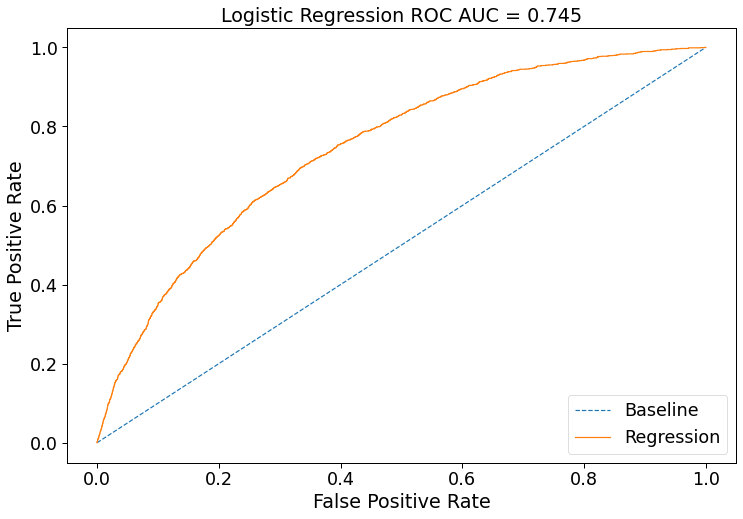

In [60]:
# Строим ROC-кривую:

probs = model_1.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [61]:
# Посмотрим на различные метрики:

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.671
f1_score: 0.342
recall_score: 0.6907
MSE: 0.329


<AxesSubplot:>

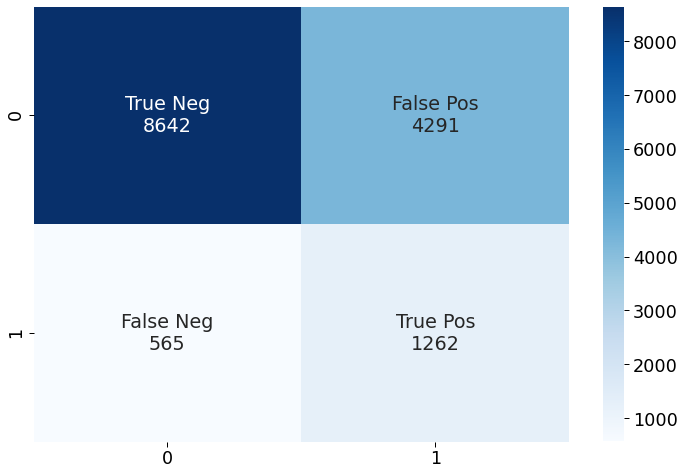

In [62]:
# Посмотрим confusion matrix:

sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=labels, fmt='', cmap='Blues')

<b>Результаты</b> настройки гиперпараметров вышли двоякими: вероятно "наивной" модели банально не хватило максимального числа итераций, т.к. гиперпараметры "по умолчанию" оказались оптимальными. Ошибка второго рода уменьшилась, мы угадали бОльшую часть дефолтных клиентов, но вместе с тем у нас сильно упала точность предсказания "хороших" клиентов. Площадь ROC-кривой почти не изменилась, но все остальные метрики (кроме accuracy_score) сильно выросли.

### 6.3 Oversampling

<AxesSubplot:xlabel='default', ylabel='count'>

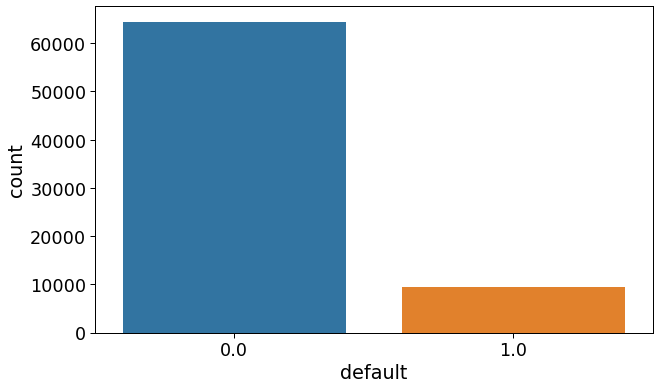

In [63]:
# Посмотрим на распределение целевого признака 'default':

plt.figure(figsize=(10, 6))
sns.countplot(x='default', data=df)

Видно что клиентов без дефолта в нашем датасете значительно больше. Попробуем использовать oversampling для выравнивания дисбаланса.

In [64]:
# Произведем простейший oversampling посредством дублирования строк с дефолтом:

#train = df.query('Train == 1').drop(['Train'], axis=1)
zeros = train[train['default'] == 0]
ones = train[train['default'] == 1]
default_new = int(len(zeros) / len(ones))
for i in range(default_new):
    train1 = train.append(ones).reset_index(drop=True)

In [65]:
# Посмотрим сколько строк добавилось к нашему датасету:

display(train1.shape[0] - train.shape[0])

9372

In [66]:
# Подготовим новые данные:

train1_cat = encoder.fit_transform(train1[cat_cols].values)
train1_num = scaler.fit_transform(train1[num_cols].values)
X = np.hstack([train1_num, train1[bin_cols].values, train1_cat])
Y = train1['default'].values

In [67]:
# Разделим данные для обучения:

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.20,
                                                    random_state=RANDOM_SEED)

In [68]:
# Обучаем модель:

model_2 = LogisticRegression(penalty='l1', class_weight='balanced', 
                             max_iter=2000, solver='liblinear', 
                             C=1.0, random_state=RANDOM_SEED)
model_2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, penalty='l1',
                   random_state=42, solver='liblinear')

In [69]:
# Делаем предсказание:

y_pred = model_2.predict(X_test)

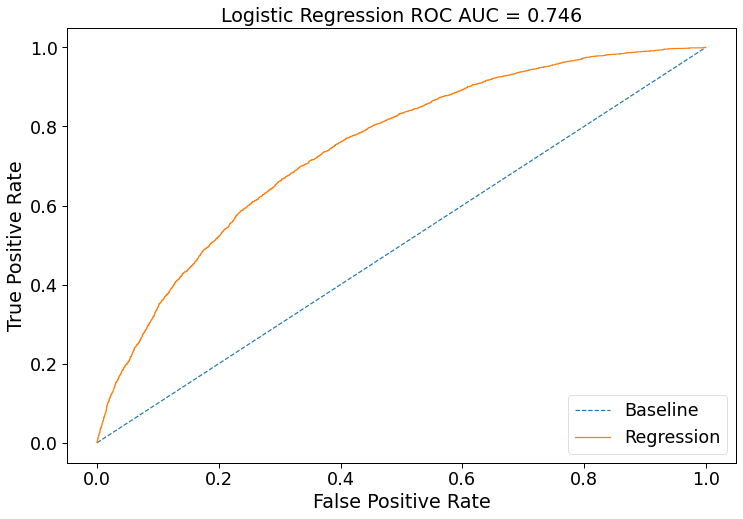

In [70]:
# Строим ROC-кривую:

probs = model_2.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [71]:
# Посмотрим на различные метрики:

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6766
f1_score: 0.4923
recall_score: 0.6905
MSE: 0.3234


<AxesSubplot:>

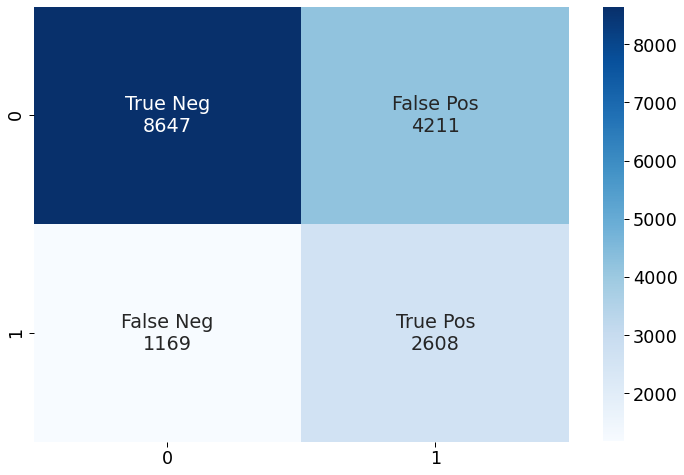

In [72]:
# Посмотрим confusion matrix:

sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=labels, fmt='', cmap='Blues')

<b>Результаты</b> оверсемплинга отличаются от предыдущей модели: площадь под ROC-кривой не изменилась, количество ошибок первого рода тоже, ошибка второго рода выросла из-за увеличения числа "дефолтных" клиентов в данных. Сильно увеличился f1_score, accuracy_score вырос минимально, совсем чуть-чуть ухудшились recall_score и MSE.

### 6.4 Oversampling + полиноминальные признаки

Попробуем улучшить предыдущую модель, добавив полиномиальные признаки.

In [73]:
# Добавим полиномиальные признаки на основе числовых признаков.

pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
df2 = df.join(poly_df, how='left')

In [74]:
# Посмотрим сколько добавилось столбцов и их названия:

display(f'Добавилось {df2.shape[1] - df.shape[1]} столбцов: {poly_cols}')

"Добавилось 15 столбцов: ['x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']"

In [75]:
# Произведем oversampling посредством дублирования строк с дефолтом:

train = df2.query('Train == 1').drop(['Train'], axis=1)
zeros = train[train['default'] == 0]
ones = train[train['default'] == 1]
default_new = int(len(zeros) / len(ones))
for i in range(default_new):
    train2 = train.append(ones).reset_index(drop=True)

In [76]:
# Создадим список числовых и полиноминальных признаков

num_poly_cols = []
num_poly_cols.extend(num_cols)
num_poly_cols.extend(poly_cols)

In [77]:
# Подготовим новые данные:

train2_cat = encoder.fit_transform(train2[cat_cols].values)
train2_num_poly = scaler.fit_transform(train2[num_poly_cols].values)
X = np.hstack([train2_num_poly, train2[bin_cols].values, train2_cat])
Y = train2['default'].values

In [78]:
# Разделим данные для обучения:

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.20,
                                                    random_state=RANDOM_SEED)

In [79]:
# Обучаем модель:

model_3 = LogisticRegression(penalty='l1', class_weight='balanced', 
                             max_iter=2000, solver='liblinear', 
                             C=1.0, random_state=RANDOM_SEED)
model_3.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, penalty='l1',
                   random_state=42, solver='liblinear')

In [80]:
# Делаем предсказание:

y_pred = model_3.predict(X_test)

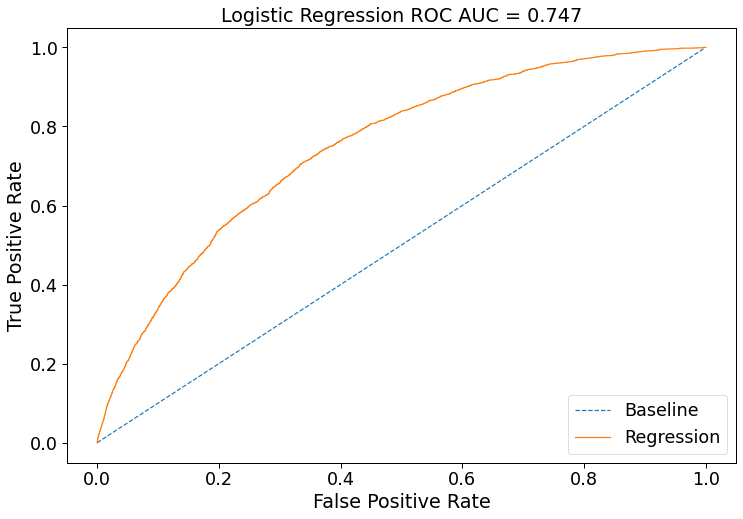

In [81]:
# Строим ROC-кривую:

probs = model_3.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [82]:
# Посмотрим на различные метрики:

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6788
f1_score: 0.4934
recall_score: 0.6889
MSE: 0.3212


<AxesSubplot:>

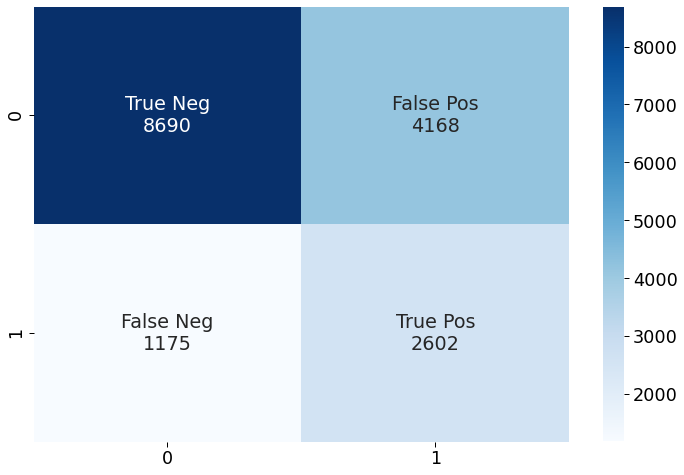

In [83]:
# Посмотрим confusion matrix:

sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=labels, fmt='', cmap='Blues')

<b>Результаты</b> по сравнению с предыдущей моделью чуть-чуть улучшились: площадь под ROC-кривой увеличилась, количество ошибок первого рода немного уменьшилось, а второго рода чуть-чуть увеличилось. Все остальные метрики, кроме MSE слегка подросли. Добавление полиноминальных признаков еще немного улучшило нашу модель.

### 6.5 Oversampling + полиноминальные признаки + работа с гиперпараметрами

Попробуем подобрать оптимальные гиперпараметры для модели, полученной на прошлом этапе.

In [95]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(class_weight='balanced', max_iter=2000, 
                           solver='liblinear', random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=2, n_jobs=6)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
best_params = best_model.best_estimator_.get_params()
print('Лучшее Penalty:', best_params['penalty'])
print('Лучшее C:', best_params['C'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 12.6min finished


Лучшее Penalty: l2
Лучшее C: 1.0


In [96]:
# Обучаем модель:

model_4 = LogisticRegression(penalty='l2', class_weight='balanced',
                             max_iter=2000, solver='liblinear', C=1)
model_4.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=2000,
                   solver='liblinear')

In [97]:
# Делаем предсказание:

y_pred = model_4.predict(X_test)

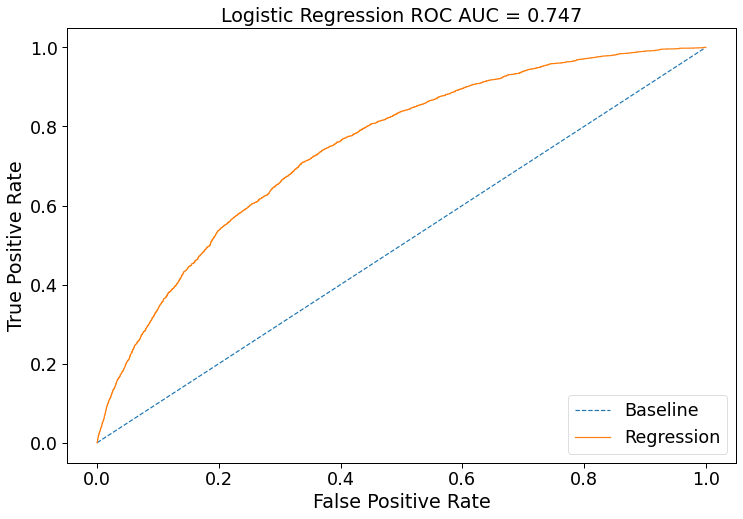

In [98]:
# Строим ROC-кривую:

probs = model_4.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [99]:
# Посмотрим на различные метрики:

print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6789
f1_score: 0.4935
recall_score: 0.6889
MSE: 0.3211


<AxesSubplot:>

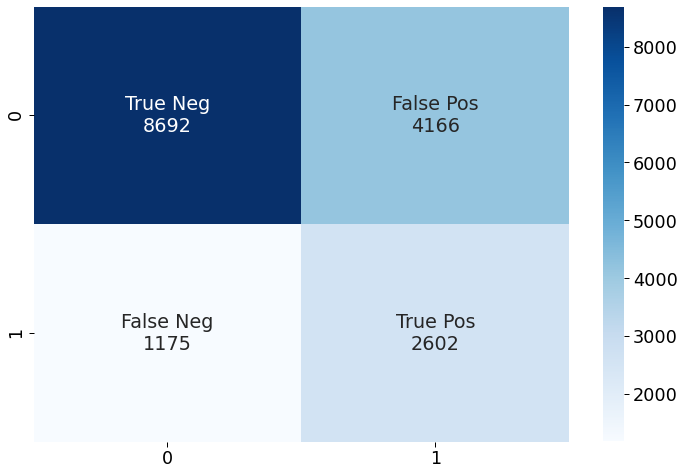

In [100]:
# Посмотрим confusion matrix:

sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=labels, fmt='', cmap='Blues')

<b>Результаты</b> по сравнению с предыдущей моделью еще чуть-чуть улучшились: площадь под ROC-кривой не изменилась, но количество ошибок первого и второго рода чуть-чуть уменьшилось, а все остальные метрики, кроме MSE еще немного подросли.
К сожалению, из-за возросшей сложности, даже рассчет самой модели идет уже не быстро, а подбор гиперпараметров (даже локально при распараллеливании процесса) занимает очень много времени. 
Данная модель лучшая из получившихся у меня на данный момент, на ней и остановимся.

## 7. Подготовка данных для соревнования

In [101]:
# Проводим преобразование тестовых данных, аналогичное преобразованию тренировочных:

test = df2.query('Train == 0').drop(['Train'], axis=1)

test_cat = encoder.transform(test[cat_cols].values)
test_num_poly = scaler.transform(test[num_poly_cols].values)

test_df = np.hstack([test_num_poly, test[bin_cols].values, test_cat])

In [102]:
# Делаем предсказание:

y_probs = model_4.predict_proba(test_df)[:,1]

In [103]:
# Подготавливаем решение:

test['default'] = y_probs
submission = test[['client_id','default']]

In [104]:
# Проверяем что получилось:

display(submission.sample(10))
display(submission.shape)

,client_id,default
82772,46328,0.228675
98338,65999,0.162013
92907,98734,0.453864
85484,15838,0.107117
91149,16846,0.302086
89087,33476,0.249867
97672,73358,0.400573
88477,40175,0.214815
80719,98250,0.057373
101612,8772,0.708690


(36349, 2)

In [105]:
# Сохраняем решение в файл:

submission.to_csv('submission.csv', index=False)